In [104]:
using DataFrames, CSV, Plots, Statistics, Query, Pipe, Indicators, HypothesisTests

In [2]:
df = CSV.File("HIST_PAINEL_COVIDBR_2021_Parte1_27ago2021.csv") |> DataFrame;
@pipe CSV.File("HIST_PAINEL_COVIDBR_2021_Parte2_27ago2021.csv") |> DataFrame |> append!(df, _)
first(df, 5)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data
,String,String?,String?,Int64,Int64?,Int64?,String?,Date…
1,Brasil,missing,missing,76,missing,missing,missing,2021-01-01
2,Brasil,missing,missing,76,missing,missing,missing,2021-01-02
3,Brasil,missing,missing,76,missing,missing,missing,2021-01-03
4,Brasil,missing,missing,76,missing,missing,missing,2021-01-04
5,Brasil,missing,missing,76,missing,missing,missing,2021-01-05


In [3]:
size(df)[1]

1342941

In [50]:
names(df)

17-element Vector{String}:
 "regiao"
 "estado"
 "municipio"
 "coduf"
 "codmun"
 "codRegiaoSaude"
 "nomeRegiaoSaude"
 "data"
 "semanaEpi"
 "populacaoTCU2019"
 "casosAcumulado"
 "casosNovos"
 "obitosAcumulado"
 "obitosNovos"
 "Recuperadosnovos"
 "emAcompanhamentoNovos"
 "interior/metropolitana"

In [5]:
dfcasos = df |> 
            @groupby({_.data}) |>
            @map({data=key(_)[1], casos=sum(_.casosNovos)}) |>
            DataFrame

first(dfcasos, 10)

,data,casos
,Date…,Int64
1,2021-01-01,73815
2,2021-01-02,47481
3,2021-01-03,52023
4,2021-01-04,60018
5,2021-01-05,169944
6,2021-01-06,190290
7,2021-01-07,263529
8,2021-01-08,156105
9,2021-01-09,186870


In [51]:
gr()

Plots.GRBackend()

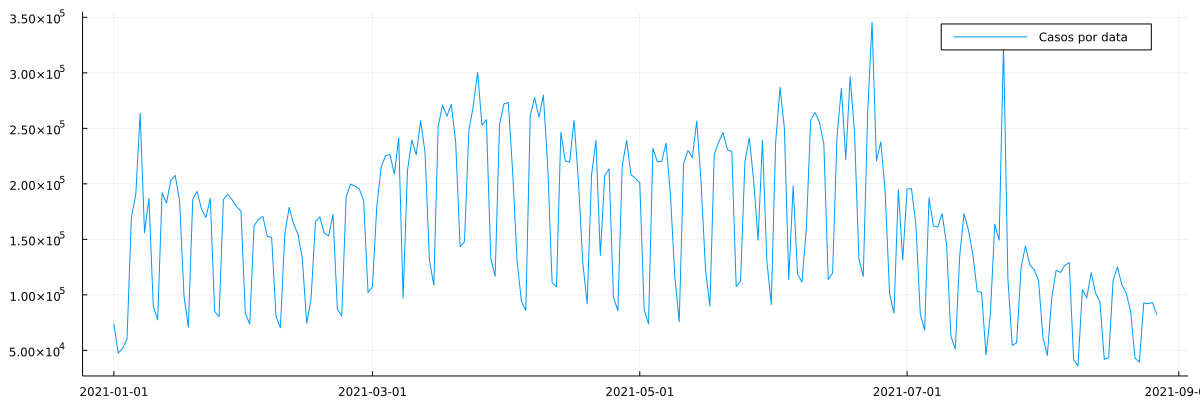

In [7]:
plot(dfcasos.data, dfcasos.casos, size=(1200, 400), label="Casos por data")

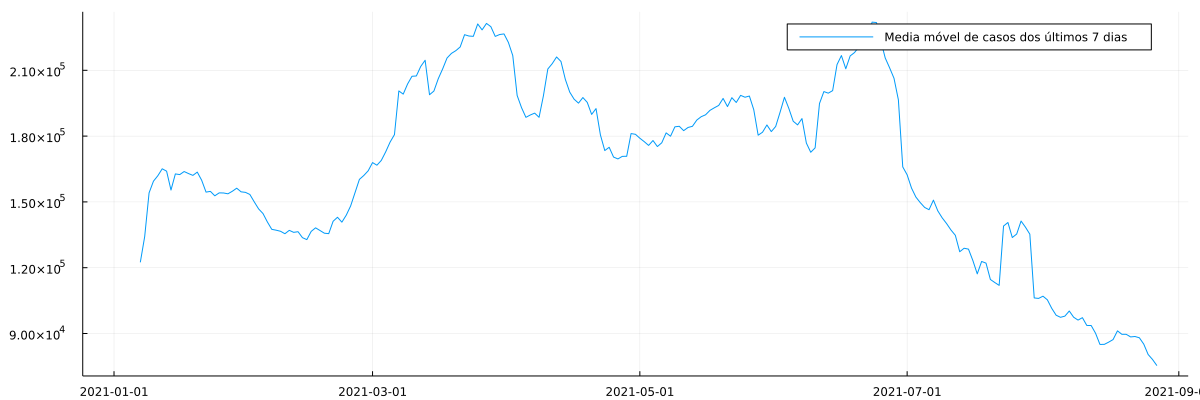

In [8]:
plot(dfcasos.data, sma(dfcasos.casos, n=7), size=(1200, 400), label="Media móvel de casos dos últimos 7 dias")

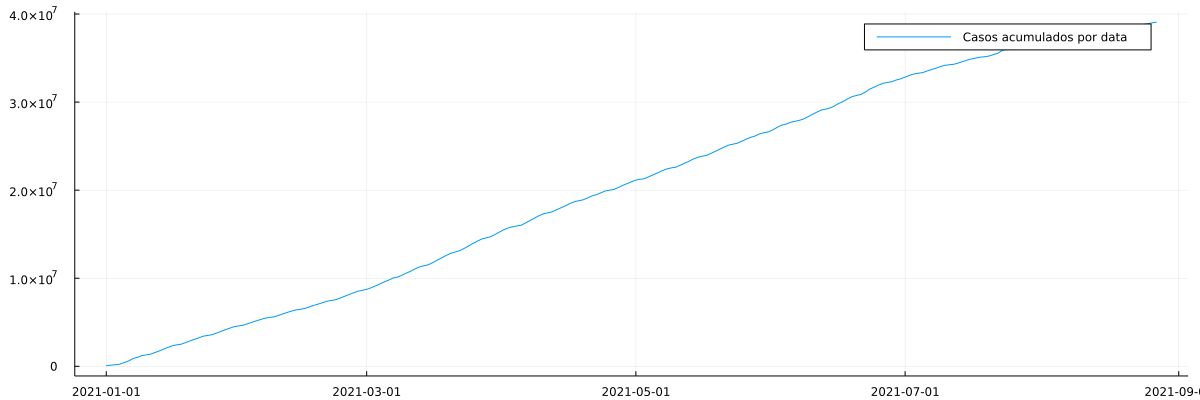

In [9]:
plot(dfcasos.data, cumsum(dfcasos.casos), size=(1200, 400), label="Casos acumulados por data")

In [10]:
vaxdf = CSV.File("vacinados_br.csv") |> DataFrame
first(vaxdf, 10)

,data,parcial,total
,Date…,Int64,Int64
1,1987-07-12,1,1
2,2011-07-04,1,1
3,2020-03-23,312872,27988
4,2021-01-01,47,1
5,2021-01-03,3,3
6,2021-01-04,37,10
7,2021-01-06,4,4
8,2021-01-07,1,3
9,2021-01-10,4,1


In [11]:
dfcasos = dfcasos |>
            @orderby(_.data) |>
            @join(vaxdf, _.data, _.data, {_.data, _.casos, __.parcial, __.total}) |>
            DataFrame

first(dfcasos, 10)

,data,casos,parcial,total
,Date…,Int64,Int64,Int64
1,2021-01-01,73815,47,1
2,2021-01-03,52023,3,3
3,2021-01-04,60018,37,10
4,2021-01-06,190290,4,4
5,2021-01-07,263529,1,3
6,2021-01-10,89376,4,1
7,2021-01-11,77466,13,1
8,2021-01-12,192075,37,14
9,2021-01-14,203274,10,5


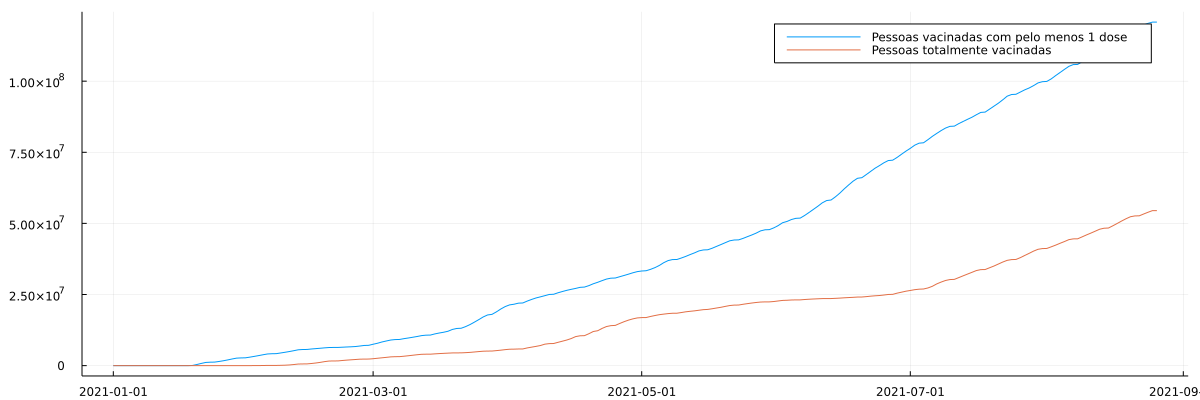

In [13]:
plot(dfcasos.data, cumsum(dfcasos.parcial), size=(1200, 400), label="Pessoas vacinadas com pelo menos 1 dose")
plot!(dfcasos.data, cumsum(dfcasos.total), label="Pessoas totalmente vacinadas")

In [68]:
dfcasos[!,:mediacasos] = sma(dfcasos.casos, n=7)
dfcasos[!,:partvax] = cumsum(dfcasos.parcial)
dfcasos[!,:vacinados] = cumsum(dfcasos.total)
correlation = cor(Matrix(dfcasos[7:end,5:end]))

3×3 Matrix{Float64}:
  1.0       -0.533184  -0.517149
 -0.533184   1.0        0.988019
 -0.517149   0.988019   1.0

Parcialmente vacinados

In [74]:
correlation[1,3]^2

0.2674426241544619

Totalmente vacinados

In [75]:
correlation[1,2]^2

0.28428474160479056

In [105]:
OneSampleZTest(atanh(correlation[1,2]), 1, nrow(dfcasos)-3)

One sample z-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.594583
    95% confidence interval: (-0.7241, -0.4651)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-18

Details:
    number of observations:   229
    z-statistic:              -8.997670298655128
    population standard error: 0.06608186004550898


In [60]:
dfobitos = df |> 
            @groupby({_.data}) |>
            @map({data=key(_)[1], obitos=sum(_.obitosNovos)}) |>
            DataFrame

first(dfobitos, 10)

,data,obitos
,Date…,Int64
1,2021-01-01,1386
2,2021-01-02,942
3,2021-01-03,879
4,2021-01-04,1629
5,2021-01-05,3513
6,2021-01-06,3726
7,2021-01-07,4572
8,2021-01-08,2886
9,2021-01-09,3513


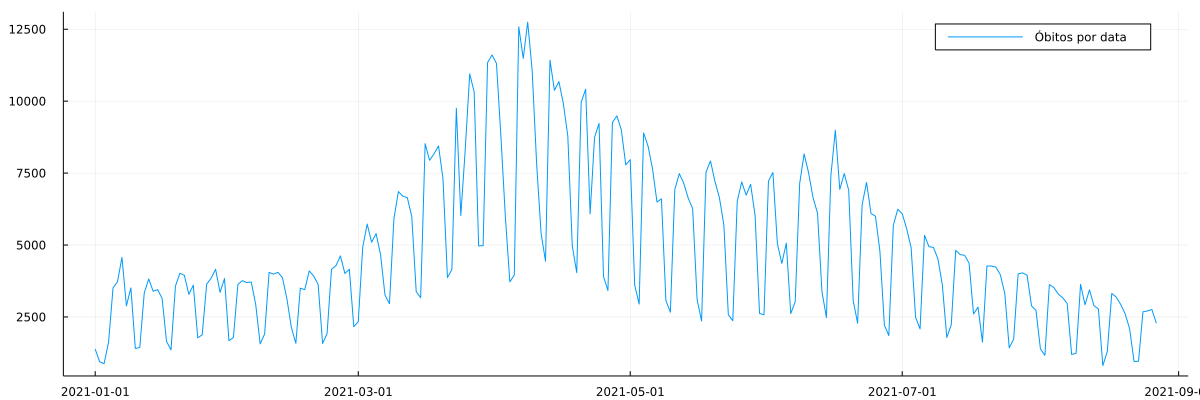

In [61]:
plot(dfobitos.data, dfobitos.obitos, size=(1200, 400), label="Óbitos por data")

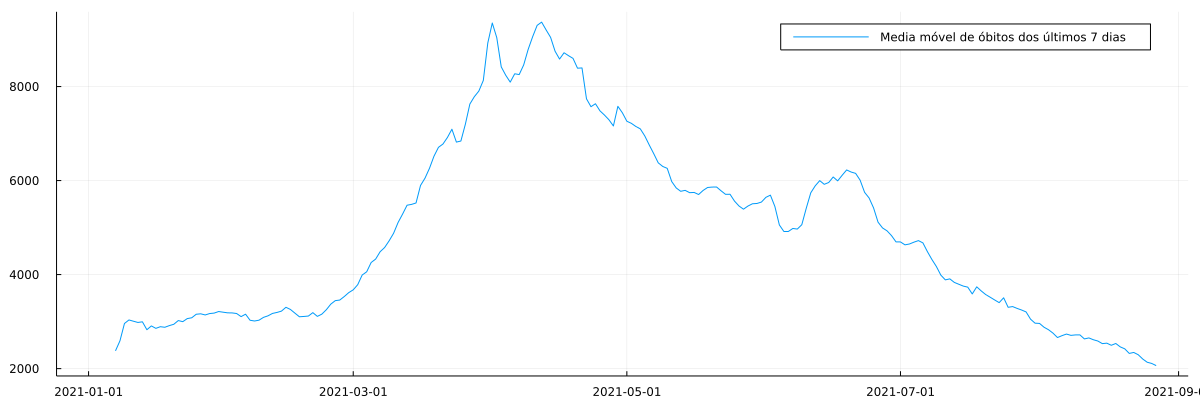

In [62]:
plot(dfobitos.data, sma(dfobitos.obitos, n=7), size=(1200, 400), label="Media móvel de óbitos dos últimos 7 dias")

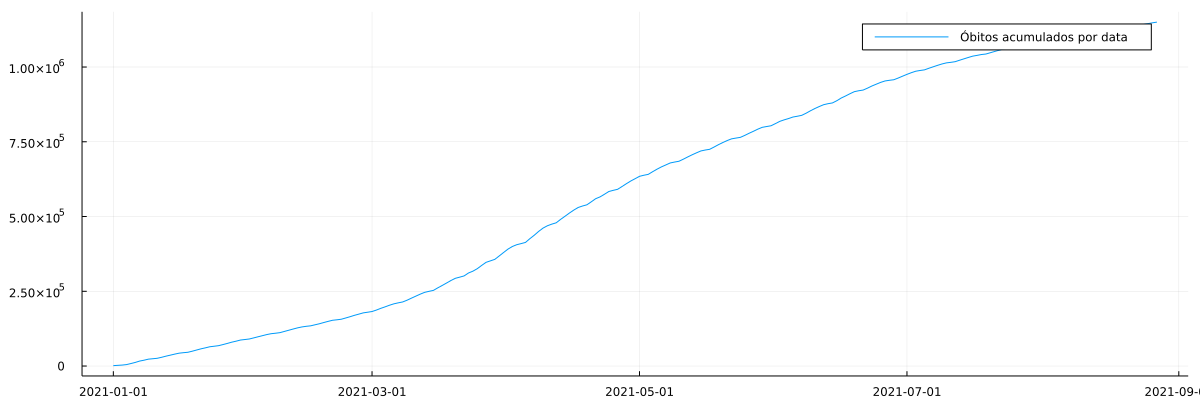

In [63]:
plot(dfobitos.data, cumsum(dfobitos.obitos), size=(1200, 400), label="Óbitos acumulados por data")

In [82]:
dfobitos = dfobitos |>
            @orderby(_.data) |>
            @join(vaxdf, _.data, _.data, {_.data, _.obitos, __.parcial, __.total}) |>
            DataFrame

first(dfobitos, 10)

,data,obitos,parcial,total
,Date…,Int64,Int64,Int64
1,2021-01-01,1386,47,1
2,2021-01-03,879,3,3
3,2021-01-04,1629,37,10
4,2021-01-06,3726,4,4
5,2021-01-07,4572,1,3
6,2021-01-10,1407,4,1
7,2021-01-11,1440,13,1
8,2021-01-12,3330,37,14
9,2021-01-14,3393,10,5


In [89]:
dfobitos[!,:mediacasos] = sma(dfobitos.obitos, n=7)
dfobitos[!,:partvax] = cumsum(dfobitos.parcial)
dfobitos[!,:vacinados] = cumsum(dfobitos.total)
obcorrelation = cor(Matrix(dfobitos[7:end,5:end]))

3×3 Matrix{Float64}:
  1.0       -0.288764  -0.292423
 -0.288764   1.0        0.988019
 -0.292423   0.988019   1.0

Parcialmente vacinados

In [76]:
obcorrelation[1,2]^2

0.08338483609490471

Totalmente vacinados

In [77]:
obcorrelation[1,3]^2

0.08551147838951463

In [103]:
OneSampleZTest(atanh(obcorrelation[1,3]), 1, nrow(dfcasos)-3)

One sample z-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.301214
    95% confidence interval: (-0.4307, -0.1717)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-05

Details:
    number of observations:   229
    z-statistic:              -4.558199272594092
    population standard error: 0.06608186004550898
